# Horizonts detection model

## Content

* [Problem description](description)
* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


<a id='description'></a>

# Problem description

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images, and could be automatically detected. Proposed model should do this by using convolutional neural network.

<a id='dataset'></a>

# Dataset

We use multiple seismic cubes, in particular, Cube 1, Cube 3 and Cube VU_ONGMK. Detailed description of each cube, including sample images, is available [here](./../datasets/Horizonts_modelling.ipynb).

Note that different propotions of sampled points are applied to each cube: approximately 40% from the first, 20% from the second, 40% from the third.

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES=1

import os
import sys
import warnings
import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

env: CUDA_VISIBLE_DEVICES=1


In [2]:
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
path_data_1 = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'
path_data_2 = '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5'

path_pc_saved = '/notebooks/SEISMIC_DATA/SAVED/ANEW/point_clouds.dill'   # path_data: point_clouds

dsi = FilesIndex(path=[path_data_0, path_data_1, path_data_2], no_ext=True)
ds = SeismicCubeset(dsi)

ds = (ds.load_geometries()
        .load_point_clouds(load_from = path_pc_saved)
        .load_labels()
        .load_samplers(p=[0.4, 0.2, 0.4])
      )
# ~80 seconds

<a id='architecture'></a>

# Model architecture

We use convonlutional neural network in `EncoderDecoder` fashion and train on crops of (256, 256, 2) size:
* First of all, initial crop is downsampled twice along xlines/heights dimensions, effectively reducing resolution 4 times
* Then, we encode crop by applying `inception_a_block` of Inception_v4 3 times with max-pooling in-between
* `Inception_c_block` is applied at the bottleneck
* Initial shape of the block is restored by transposed convolutions with ordinary convolutions+batchnorm+activation(ReLU) in-between

Multiple things are worth noting. Most importantly, model percieves every crop (a 3-d entity) as sequence of 2-d images stacked one after the other, and every convolution that is used is 2D.
Every max-pooling in the network is of size and stride 2, effectively halving the resolution of its inputs. To get precise definitions of `Inception` blocks, check [this](https://arxiv.org/pdf/1602.07261.pdf) paper.

Technical note: in order to compute `Dice`-coefficient, we need to add axis both to the output of neural network and to initial labels. That is done via `predictions` callable in the first case and `add_axis` action in the second.

In [3]:
# SHAPES
EPOCHS = 1000
NUM_CROPS = 64
CROP_SHAPE = [2, 256, 256]                              # i, x, h
MODEL_SHAPE = CROP_SHAPE[-2:] + [CROP_SHAPE[0]]         # x, h, i
MODEL_SHAPE_DICE = MODEL_SHAPE + [1]

MODEL_SHAPE = tuple(MODEL_SHAPE)
MODEL_SHAPE_DICE = tuple(MODEL_SHAPE_DICE)

In [4]:
# Custom ED class is to ensure that `head` block does not `crop` its inputs. 
# For more on that, check the `head` method of EncoderDecoder
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)
        with tf.variable_scope(name):
            channels = cls.num_channels(targets)
            x = conv_block(inputs, filters=channels, **kwargs)
        return x


# ED config
def predictions(x):
    return tf.expand_dims(x, axis=-1, name='expand')

model_config = {
    'inputs': dict(cubes={'shape': MODEL_SHAPE},
                   masks={'name': 'targets', 'shape': MODEL_SHAPE_DICE}), 
    'initial_block/inputs': 'cubes',
    'initial_block': {'layout': 'pp'},
    'body/encoder': {'num_stages': 3,
                     'blocks': {'base': Inception_v4.inception_a_block,
                                'filters': [[32, 16], [48, 32], [64, 48]]}},
    'body/embedding': {'base': Inception_v4.inception_c_block, 'filters': [32, 48, 64, 96]},
    'body/decoder': {'num_stages': 5, 'blocks': {'layout':'cna', 'filters': [32, 16, 8, 6, 4]}},
    'loss': 'dice',
    'optimizer': 'Adam',
    'predictions': predictions,
    'output': 'sigmoid',
    'common': {'data_format': 'channels_last'}
}

pipeline_config = {'model': ED,
                   'model_config': model_config,
                   'num_crops': NUM_CROPS}

<a id='training'></a>

# Training

Neural network is trained on crops of fixed shape. Pipeline consists of following steps:

* First of all, we create positions of crops, then load actual data and labels for it
* Then we scale values: that is done in order to equalize value ranges for different cubes
* Right after, multiple augmentations are applied to simulate different distortions and make model robust to them
* Model weights update

Every batch contains 64 crops. Model is trained for 500 epochs with `Adam` optimizer with default parameters. Loss-function: `Dice`-coefficient.


In [5]:
train_pipeline = (Pipeline(config=pipeline_config)
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(ds.sampler.truncate(high=0.8, expr=lambda p: p[:, 1]).sample, NUM_CROPS), shape=CROP_SHAPE)
                  .load_cubes(dst='data_crops')
                  .create_masks(dst='mask_crops', width=1)
                  .rotate_axes(src=['data_crops', 'mask_crops'])
                  .scale(mode='normalize', src='data_crops')
                  # Augmentations
                  .additive_noise(scale=0.005, src='data_crops', dst='data_crops', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)), src=['data_crops', 'mask_crops'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)), src=['data_crops', 'mask_crops'], p=0.4)
                  .cutout_2d(patch_shape=P(R('uniform', 10, 30, size=2)), n=P(R('uniform', 3, 17)), src='data_crops', p=0.2)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['data_crops', 'mask_crops'], p=0.2)
                  # Training
                  .add_axis(src='mask_crops', dst='mask_crops')
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('current_loss')
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  .train_model('ED', 
                               fetches='loss', make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')},
                               save_to=V('current_loss'))
                  .update_variable('loss_history', 
                                   V('current_loss'), 
                                   mode='a')) << ds
loss_history = []

In [6]:
# Test that everything is fine and model is trainable
with tqdm(total=EPOCHS, smoothing=0.3) as pbar:
    for e in range(1, EPOCHS+1):
        train_batch = train_pipeline.next_batch(3, n_epochs=None)
        current_loss = train_pipeline.get_variable("current_loss")
        loss_history.append(current_loss)

        pbar.set_description('Loss:{:12.7}'.format(current_loss))
        pbar.update(1)

Loss:   -0.713267: 100%|██████████| 1000/1000 [46:11<00:00,  2.51s/it]


Loss against iterations:

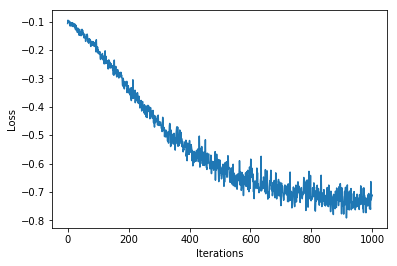

In [7]:
plt.plot(loss_history)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

<a id='validation'></a>

# Validation

Now, we want to check performance of our model on unseen part of the cubes. 

In [8]:
val_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(ds.sampler.truncate(low=0.9, expr=lambda p: p[:, 1], prob=0.1).sample, NUM_CROPS),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .add_axis(src='mask_crops', dst='mask_crops')
                 .import_model('ED', train_pipeline)
                 .init_variable('result', init_on_each_run=list()) 
                 .predict_model('ED', 
                                fetches=['cubes', 'masks', 'predictions', 'loss'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=V('result'), mode='a')
                 ) << ds

val_batch = val_pipeline.next_batch(3, n_epochs=None)

Loss is:  -0.55341315
E_anon


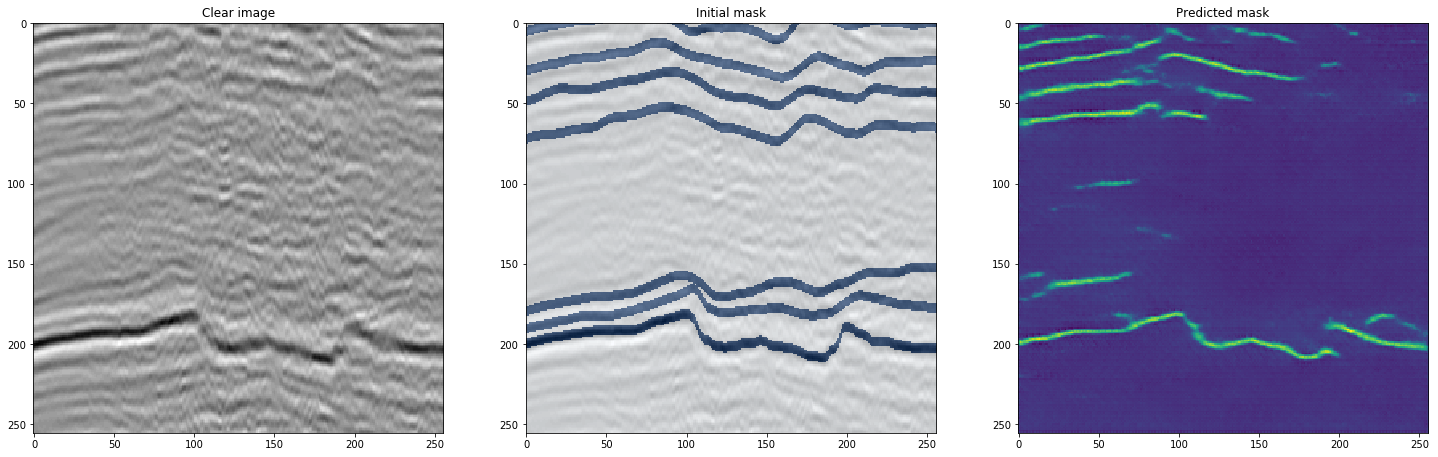

P_cube


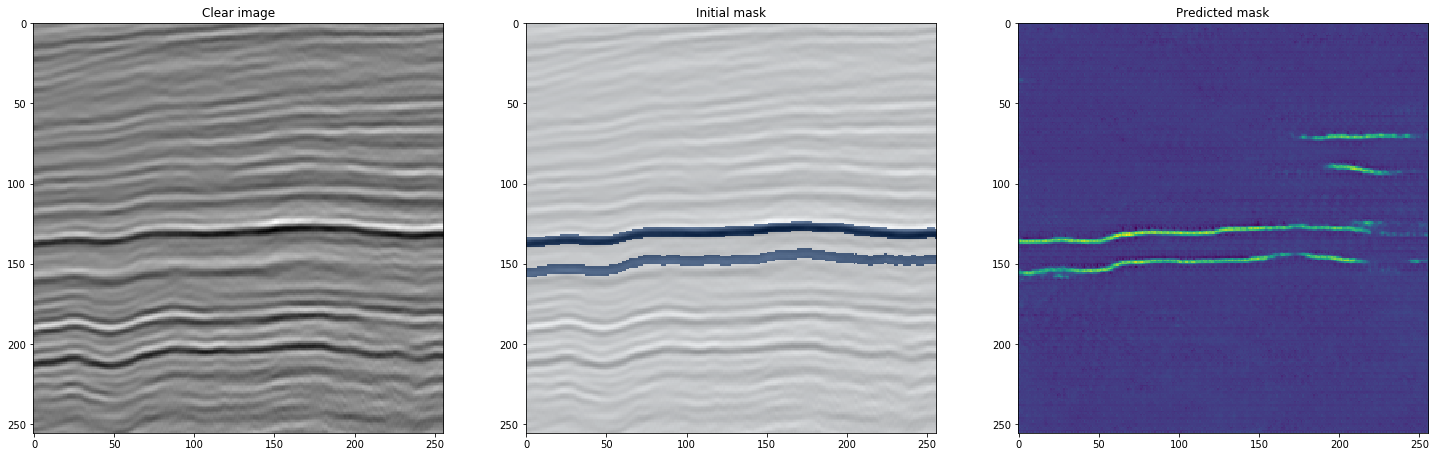

E_anon


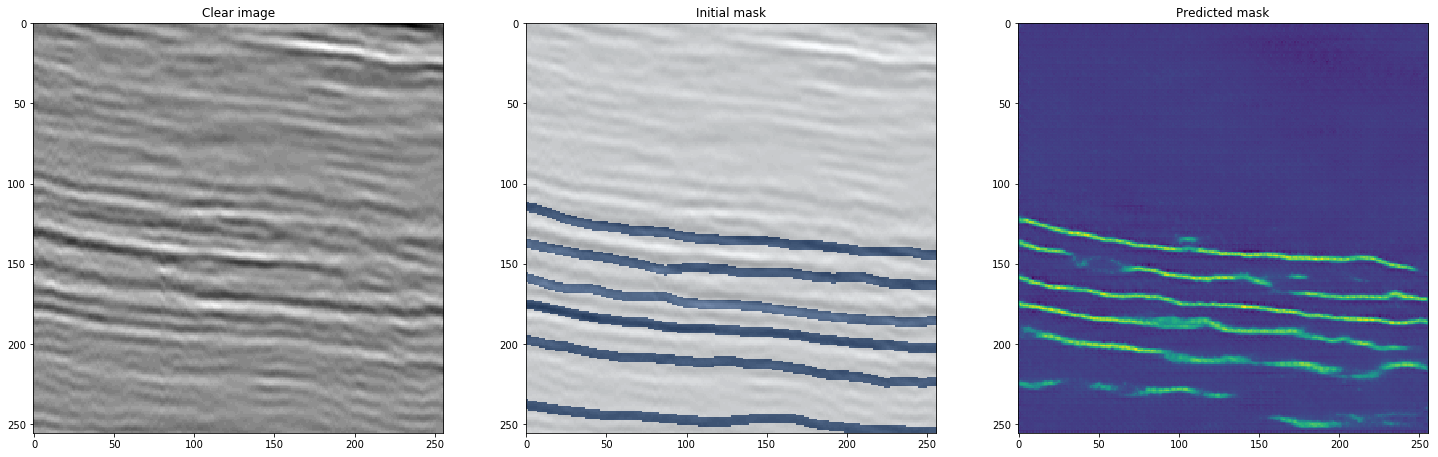

P_cube


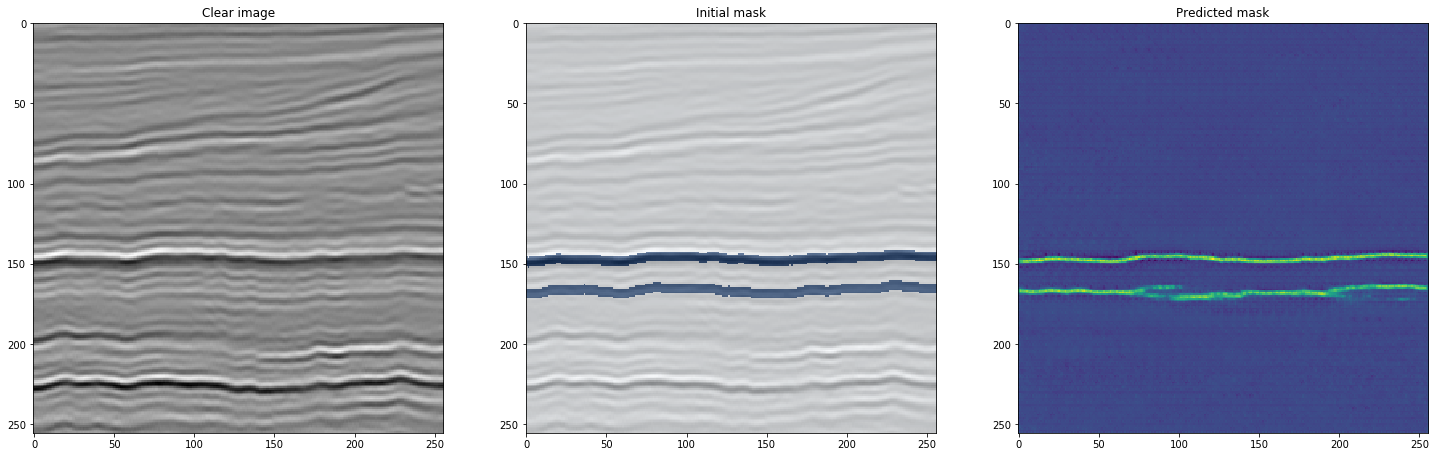

E_anon


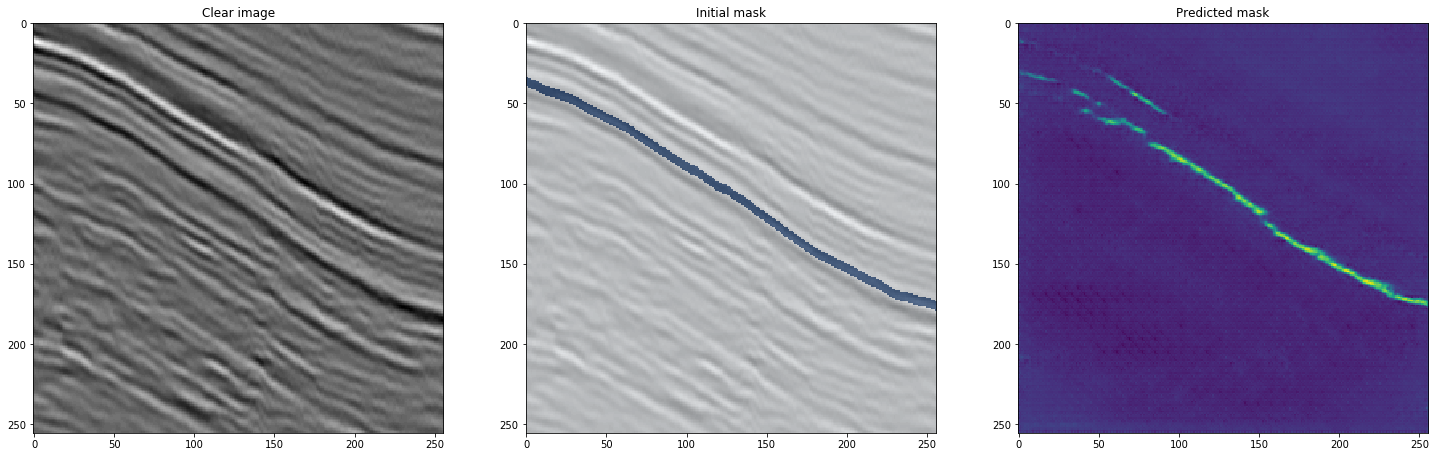

In [9]:
print('Loss is: ', val_pipeline.get_variable('result')[0][3])

for cube in np.random.choice(NUM_CROPS, 5):
    print(val_batch.indices[cube][:-10])
    iline = 0
    
    img =            val_pipeline.get_variable('result')[0][0][cube, :, :, iline].T
    masks =          val_pipeline.get_variable('result')[0][1][cube, :, :, iline, 0].T
    predicted_mask = val_pipeline.get_variable('result')[0][2][cube, :, :, iline, 0].T
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Clear image')
    
    ax[1].imshow(masks, cmap="Blues")
    ax[1].imshow(img, cmap="gray", alpha=0.5)
    ax[1].imshow(masks, cmap="Blues", alpha=0.1)
    ax[1].set_title('Target mask')

    ax[2].imshow(predicted_mask)
    ax[2].set_title('Predicted mask')

    plt.show()

It is way easier to analyse results when multiple crops are glued together in one big slide:

In [ ]:
%%time
ds = ds.make_grid(ds.indices[0], CROP_SHAPE, 
                  [2201, 2202], [0, 800], [100, 1300],
                  strides=[1, 128, 128])

print('Shape of grid:', ds.grid_info['grid_array'].shape)

pred_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .add_axis(src='mask_crops')
                 # Predictions
                 .import_model('ED', train_pipeline)
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_masks', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .predict_model('ED', 
                                fetches=['cubes', 'masks', 'predictions'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=[V('result_cubes'), V('result_masks'), V('result_preds')], mode='e')
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_masks'), dst='assembled_mask',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'), mode='max')
                 ) << ds

for _ in range(ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

Due to slow changes in data along ilines in any given cube, it might be a good idea to test our model against completely new cube. To begin with, we need to load it:

In [10]:
%%time
test_path_data =           '/notebooks/SEISMIC_DATA/CUBE_2/M_cube.hdf5'
test_save_dir =              '/notebooks/tsimfer/SAVED/CUBE_2/'

test_path_pc_saved =       test_save_dir + 'point_clouds.dill'   # path_data: point_clouds

test_dsi = FilesIndex(path=[test_path_data], no_ext=True)
test_ds = SeismicCubeset(test_dsi)

test_paths_txt = {test_ds.indices[0]: glob('/notebooks/SEISMIC_DATA/CUBE_2/HORIZONTS/*.txt')}

test_ds = (test_ds.load_geometries()
                  .load_point_clouds(paths = test_paths_txt)
                  .load_labels()
                  .load_samplers())

## ~ 3 seconds

CPU times: user 3.07 s, sys: 228 ms, total: 3.3 s
Wall time: 3.53 s


In [11]:
%%time
test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE, 
                            [201, 202], [0, 800], [100, 1300],
                            strides=[1, 128, 128])

print('Shape of grid:', test_ds.grid_info['grid_array'].shape)

pred_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .add_axis(src='mask_crops')
                 # Predictions
                 .import_model('ED', train_pipeline)
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_masks', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .predict_model('ED', 
                                fetches=['cubes', 'masks', 'predictions'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=[V('result_cubes'), V('result_masks'), V('result_preds')], mode='e')
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_masks'), dst='assembled_mask',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'), mode='max')
                 ) << test_ds

for _ in range(test_ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

Shape of grid: (100, 3)
CPU times: user 9.71 s, sys: 1.53 s, total: 11.2 s
Wall time: 10.8 s


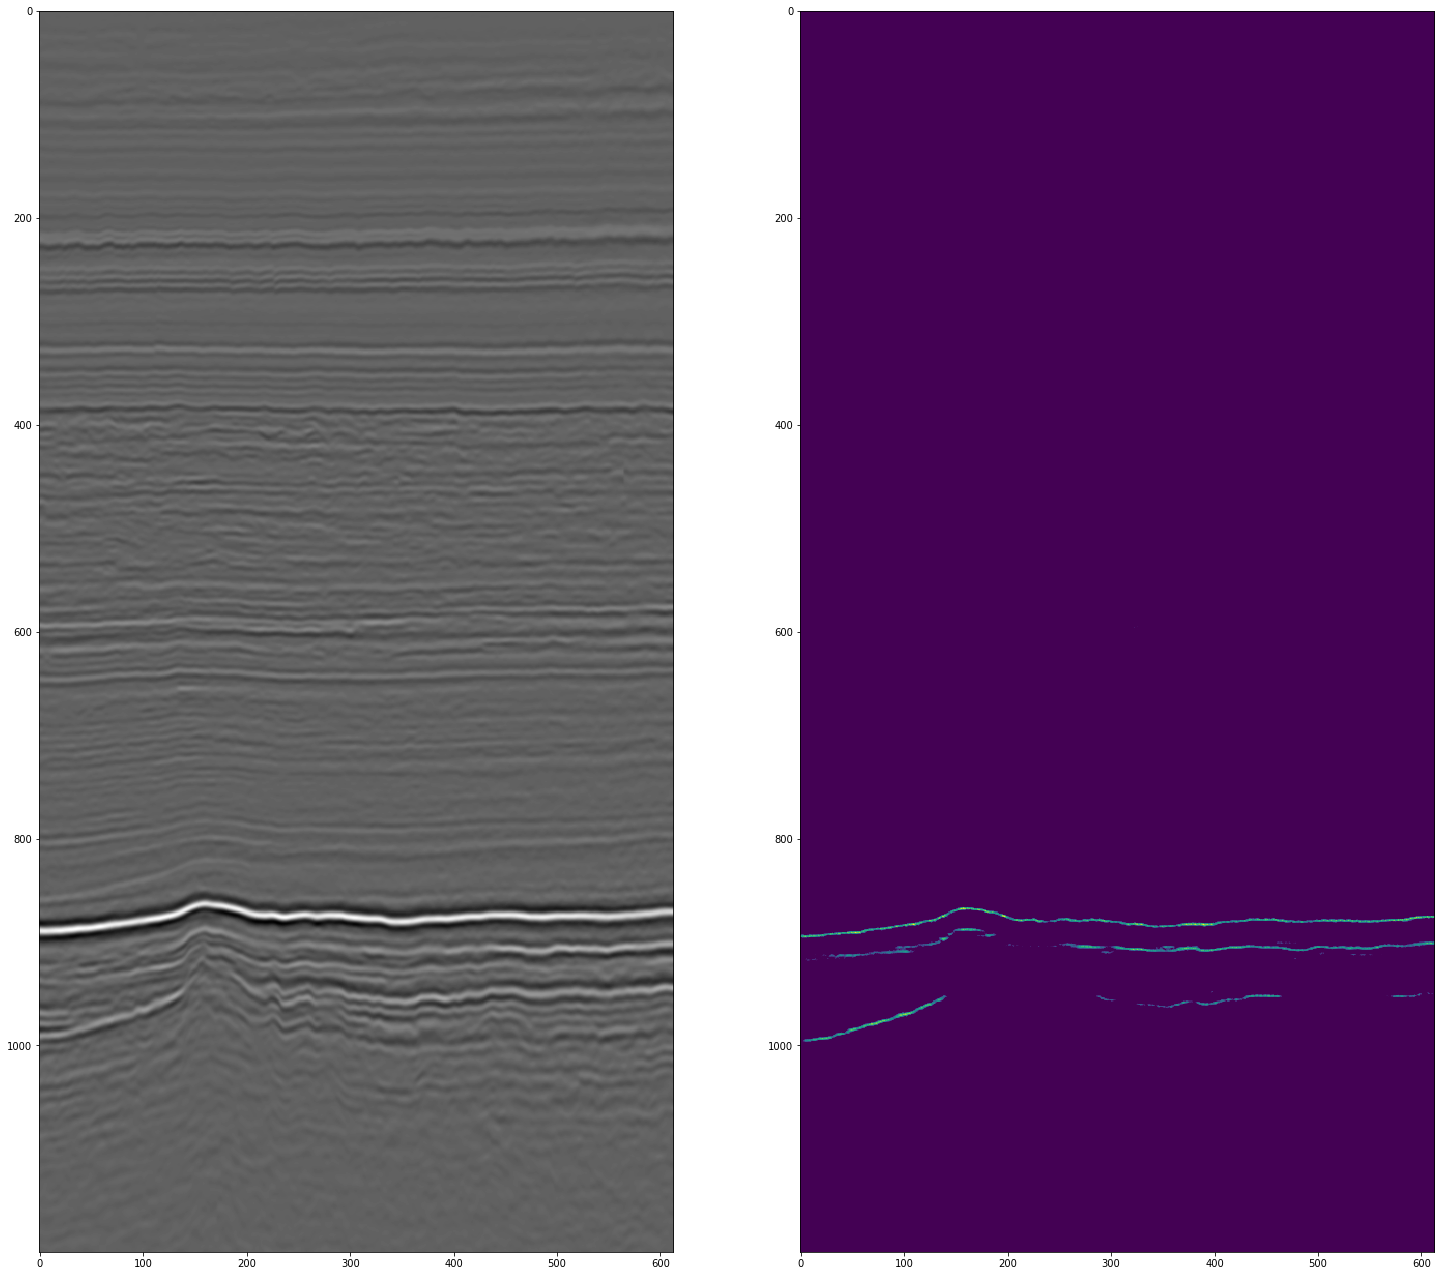

In [12]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[0, :, :].T, cmap='gray')
ax[1].imshow(pred_full[0, :, :].T)
plt.show()

Finally, it is time to save the model:

In [14]:
save_dir = '/notebooks/SEISMIC_DATA/SAVED/MODELS/'
name = 'ED'

dir_ = save_dir + name + '/'
try:
    os.mkdir(dir_)
except FileExistsError:
    pass

def _convert(config):
    for key, value in config.items():
        if isinstance(value, dict):
            _convert(value)
        else:
            config[key] = str(value)

_convert(pipeline_config)
with open(dir_+'config.json', 'w') as f:
    json.dump(pipeline_config, f)


train_pipeline.save_model('ED', dir_)

<a id='criticism'></a>

# Criticism

Currently, model evalution is not fully automated: making one big script to get single number is instrumental in model analysis.

<a id='conclusion'></a>

# Conclusion

<a id='suggestions'></a>

# Suggestions for improvements

* add non-regular grid for assemble_crops

* improve conventions inside of the assemble_grid

* make whole end-to-end pipeline of model evaluation